# Conducting Scaling Experiments with Modalities

In this tutorial, we showcase how the profiling and benchmark tooling within Modalities can be used to determine the training configurations that maximize throughput for a varying number of ranks (i.e., scaling benchmarks).

Generally, there are two types of scaling benchmarkings. In the first case, one wants demonstrate linear scalability of the framework on a given HPC cluster. By varying the configuration parameters most relevant for efficiency (e.g., batch size and activation checkpointing variant), we determine the maximum throughput across different number of ranks. Plotting the maximum throughput against the number of ranks should yield a linear relationship.

In the second case, we only want to determine the optimal settings for a fixed number of ranks and perform a higher dimensional and more granular grid search. This is typically the case, when you received a GPU allocation on an HPC cluster and want to maximize the efficiency of your specific training run. 

In this tutorial, we will cover both cases in the following sections.

The file tree provides an overview on the overall setup:

```txt
.
├── scaling_tutorial.ipynb      # The actual tutorial with code and explantations
├── config_8B_scaling.yaml      # The 8B model benchmarking config including grid search definition
├── experiments                 # Here, the results will be stored
├── logs                        # Here, the logs will be stored (error and stdout)
├── README.md                   # Overview on the tutorial
├── run_array_jobs.sh           # Submits the scaling experiments by calling the sbatch script`submit_job.sbatch` (once per node configuration)
├── scaling_grid_search.py      # CMD entrypoint that runs the grid search on a fixed number of ranks
└── submit_job.sbatch           # Submits the grid search for a fixed number of ranks to slurm and internally calls `scaling_grid_search.py`.
```

Note, that this tutorial is partially specific to the Leonardo supercomputer (e.g., parts of `submit_job.sbatch`) and while we tried to minimize this dependency some settings nevertheless have to be adapted for other HPC clusters. We mention these cases throughout the tutorial.  

In [7]:
import pandas as pd
from modalities.utils.profilers.profile_logs_analyzers import ProfileLogsAnalyzer
from modalities.utils.profilers.modalities_profiler import ProfilingResult
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display

## Scaling benchmarks across varying number of ranks
In this section, we want to verify the linear scalability of Modalities. 


### Running the scaling experiments


To do so, we will run a grid search over the batch size and sequence length for a varying number of ranks, as defined in `config_8B_scaling.yaml`. 


```yaml
  grid_search:
    sequence_length: [8192]     # Fixed
    vocab_size: [50304]         # Fixed
    batch_size: [1, 2, 3, 4]    # Varied 
```


When generating the concrete configurations for the grid search, the batch size array will be replaced with the concrete scalar value. Throughout the config the values are referenced, as shown below for the `dataset_batch_generator` component:

```yaml
dataset_batch_generator:
  component_key: dataset_batch_generator
  variant_key: random
  config:
    vocab_size: ${settings.grid_search.vocab_size}
    sequence_length: ${settings.grid_search.sequence_length}
    batch_size: ${settings.grid_search.batch_size}
```


The model itself is a standard LLama-like 8B model, fully sharded with FSDP2 and optimized with AdamW.
In contrast to the normal training runs, we don't specify an actual dataset. Instead we generate random batches with random tokens. 

The results and logs will be stored in the `experiments` and `logs` folder, respectively.


We submit the job array for different number of ranks via `sh run_array_jobs.sh <list of number of ranks>`. Each job will then run the grid search for the respective number of ranks by calling the sbatch script `submit_job.sbatch`. The sbatch script is responsible for setting up the environment and calling the actual grid search script `scaling_grid_search.py`.

**Note that, the specified** `partition`, `account`, `qos`, `gres` **(number of GPUs per node),** `cpus-per-task` **and loaded python environment and modules are specific to the Leonardo supercomputer and would have to be adapted for other HPC clusters.**

In [8]:
! bash run_array_jobs.sh \
  --config_file config_8B_scaling.yaml \
  --experiment_folder experiments/ \
  --python_env_path /leonardo_scratch/fast/EUHPC_D21_101/max_lue/python_envs/working/leonardo_modalities/bin/activate \
  --num_warmup_steps 4 \
  --num_measurement_steps 8 \
  --node_counts "1 2 4 8 16 32"

Using experiment folder path: experiments//2025-06-05__16-17-14_1dfeca4b
Submitting job with 1 node(s)...
Submitted batch job 16413453
Submitting job with 2 node(s)...
Submitted batch job 16413454
Submitting job with 4 node(s)...
Submitted batch job 16413455
Submitting job with 8 node(s)...
Submitted batch job 16413456
Submitting job with 16 node(s)...
Submitted batch job 16413457
Submitting job with 32 node(s)...
Submitted batch job 16413458


After all jobs have finished, the results can be found in the `experiments` folder, following the structure `num_ranks_<number of ranks>/<config hash value>_<rank_id>.json`.

```txt
experiments/2025-06-03__18-03-46/
├── num_ranks_4
│   ├── 20269a77_0.json
│   ├── 20269a77_1.json
│   ├── 20269a77_2.json
│   ...
│   ├── e9ab8d32_1.json
│   ├── e9ab8d32_2.json
│   └── e9ab8d32_3.json
└── num_ranks_8
    ├── 20269a77_0.json
    ├── 20269a77_1.json
    ├── 20269a77_2.json
    ...
    ├── e9ab8d32_5.json
    ├── e9ab8d32_6.json
    └── e9ab8d32_7.json
```


We perform rank-wise measurements, tracking the grid search config, environment information and the actual measurement results (peak memory, forward time, backward time and step time). If the job failed, e.g., due to an OOM due to batch size being too large, the error message is also stored in the result file.

```json
{
    "grid_search_config": {
        "batch_size": 1,
        "sequence_length": 4096,
        "vocab_size": 50304
    },
    "env_info": {
        "local_rank": 0,
        "global_rank": 0,
        "num_ranks": 8,
        "hostname": "lrdn1323.leonardo.local"
    },
    "measurement": {
        "peak_memory": 34438.70068359375,
        "forward_time": 0.057291507720947266,
        "backward_time": 0.5151477009057999,
        "step_time": 0.17779622972011566
    },
    "error": ""
}
```

### Analyzing the results

To verify the linear scalability of Modalities on a HPC cluster, we first load the all the results from the experiments folder (i.e., `experiments/2025-06-03__18-03-46/`) into memory. 

In [9]:
experiment_folder_path = Path("experiments/2025-06-03__19-12-57")
experiment_dirs = list(experiment_folder_path.glob("*"))
experiment_dirs

[PosixPath('experiments/2025-06-03__19-12-57/num_ranks_32'),
 PosixPath('experiments/2025-06-03__19-12-57/num_ranks_8'),
 PosixPath('experiments/2025-06-03__19-12-57/num_ranks_128'),
 PosixPath('experiments/2025-06-03__19-12-57/num_ranks_4'),
 PosixPath('experiments/2025-06-03__19-12-57/num_ranks_64'),
 PosixPath('experiments/2025-06-03__19-12-57/num_ranks_16')]

In [10]:
grid_search_dims = ["batch_size", "sequence_length", "num_ranks"]

We load the results into a single data frame. Each row corresponds to a single rank measurement, with the columns belonging to the grid search config, environment information or the actual measurement results. 

Note that some of the runs typically fail due OOM errors due to, e.g., the batch size being too large. In fact, this is wanted as we want to maxout the memory usage for the given number of ranks, to capture the full range of possible configurations. 

In [11]:
results_list: list[pd.DataFrame] = []
for experiment_dir in experiment_dirs:
    results: list[ProfilingResult] = ProfileLogsAnalyzer.load_profiling_logs(experiment_dir)
    df: pd.DataFrame = ProfileLogsAnalyzer.to_pandas_df(results)
    results_list.append(df)

df_results = pd.concat(results_list, ignore_index=True)
df_results.head()

,batch_size,sequence_length,vocab_size,local_rank,global_rank,num_ranks,hostname,peak_memory,forward_time,backward_time,step_time,error
0,3,8192,50304,0,24,32,lrdn2732.leonardo.local,-1.000000,-1.000000,-1.000000,-1.000000,CUDA out of memory. Tried to allocate 192.00 M...
1,4,4096,50304,0,8,32,lrdn1705.leonardo.local,-1.000000,-1.000000,-1.000000,-1.000000,CUDA out of memory. Tried to allocate 448.00 M...
2,3,8192,50304,0,20,32,lrdn2715.leonardo.local,-1.000000,-1.000000,-1.000000,-1.000000,CUDA out of memory. Tried to allocate 192.00 M...
3,4,2048,50304,0,0,32,lrdn2535.leonardo.local,48777.051270,0.056596,0.969817,0.097184,
4,2,2048,50304,1,29,32,lrdn2873.leonardo.local,26478.754395,0.056033,0.583824,0.056544,


The dataframe above contains only rudimentary measurement information. In the first step, we derive sample throughput and token throught put per rank and per configuration. We also remove the failed runs.

In [12]:
df_results["total_step_time"] = df_results["forward_time"] + df_results["backward_time"] + df_results["step_time"]
df_results["token_throughput"] = df_results["sequence_length"] * df_results["batch_size"] / df_results["total_step_time"]
df_results["sample_throughput"] = df_results["token_throughput"] / df_results["sequence_length"]
df_results = df_results[df_results["error"] == ""]

df_results.sort_values(by=["total_step_time"], inplace=True, ascending=True)
df_results.head()


,batch_size,sequence_length,vocab_size,local_rank,global_rank,num_ranks,hostname,peak_memory,forward_time,backward_time,step_time,error,total_step_time,token_throughput,sample_throughput
2027,1,2048,50304,3,3,4,lrdn0197.leonardo.local,35296.321289,0.058751,0.288098,0.185053,,0.531902,3850.335379,1.880047
2042,1,2048,50304,0,0,4,lrdn0197.leonardo.local,35296.321289,0.057893,0.289687,0.185252,,0.532832,3843.611730,1.876764
2062,1,2048,50304,1,1,4,lrdn0197.leonardo.local,35296.321289,0.059706,0.288424,0.185353,,0.533483,3838.921211,1.874473
2055,1,2048,50304,2,2,4,lrdn0197.leonardo.local,35296.321289,0.058486,0.289877,0.185235,,0.533598,3838.094875,1.874070
2554,1,2048,50304,0,60,64,lrdn0209.leonardo.local,14428.253906,0.057207,0.455294,0.026492,,0.538993,3799.678492,1.855312


Since the results are still per rank and per configuration, we aggregate the results by grouping by the grid search dimensions and taking the sum of `token_throughput` and `sample_throughput` and the max of  `peak_memory`. After sorting data frame by the `sample_throughput`, we see  that the token throughput increases with the number ranks and sequence length. As a sidenote, if we fix the number of ranks (e.g., to 128), halving the batch size while doubling the sequence length leads to a higher token throughput, even though the total number of tokens processed per step remains the same and attention is $O(N^2)$ w.r.t. sequence length. This can be attributed to advancements in hardware utilization with increasing sequence length. For instance Flash-Attention showed increasing throughput for backward and forward passes for longer sequences and generally a reduced memory footprint in comparison to a standard attention implementation.   

In [13]:
# aggregate over the ranks of each experiment
agg_df = df_results.groupby(grid_search_dims).agg({
        "token_throughput": "sum",
        "sample_throughput": "sum",
        "peak_memory": "max"
    }).reset_index()

agg_df.sort_values(by=["sequence_length", "token_throughput"], ascending=False)

,batch_size,sequence_length,num_ranks,token_throughput,sample_throughput,peak_memory
16,1,8192,128,889939.921133,108.635244,46901.129395
15,1,8192,64,414761.686864,50.630089,47567.082520
14,1,8192,32,214626.351523,26.199506,48874.926270
13,1,8192,16,101812.336060,12.428264,51513.366699
12,1,8192,8,25679.271291,3.134677,56797.747559
27,2,4096,128,938647.708813,229.162038,46834.816895
11,1,4096,128,731218.975013,178.520258,24540.973145
26,2,4096,64,468473.569060,114.373430,47492.332520
10,1,4096,64,376902.911336,92.017312,25190.973145
25,2,4096,32,229355.610550,55.995022,48809.051270


Next, we need the maximum throughput for each number of ranks and sequence length. We group by `num_ranks` and `sequence_length`, and aggregate along the batch size dimension by keeping only the row with the highest `token_throughput` for each group. Generally, we can see that throughput increases with number of ranks and sequence length.

In [14]:
# Group by 'num_ranks' and 'sequence_length' and keep row with max 'token_throughput'
filtered_df = agg_df.loc[agg_df.groupby(['num_ranks', 'sequence_length'])['token_throughput'].idxmax()]

# Optional: reset the index if you want a clean DataFrame
filtered_df = filtered_df.reset_index(drop=True)
filtered_df

,batch_size,sequence_length,num_ranks,token_throughput,sample_throughput,peak_memory
0,2,2048,4,18638.547231,9.100853,44982.962402
1,1,4096,4,18088.225846,4.416071,45014.962402
2,3,2048,8,48876.273119,23.865368,45381.200684
3,1,4096,8,43496.198726,10.619189,34438.700684
4,1,8192,8,25679.271291,3.134677,56797.747559
5,4,2048,16,111857.296408,54.617821,51418.241699
6,2,4096,16,108743.494784,26.548705,51450.241699
7,1,8192,16,101812.336060,12.428264,51513.366699
8,4,2048,32,233023.161016,113.780840,48777.051270
9,2,4096,32,229355.610550,55.995022,48809.051270


Plotting the sample throughput against the number of ranks, we can see that the throughput increases linearly with the number of ranks. This is a good indication that Modalities scales well on the Leonardo supercomputer.

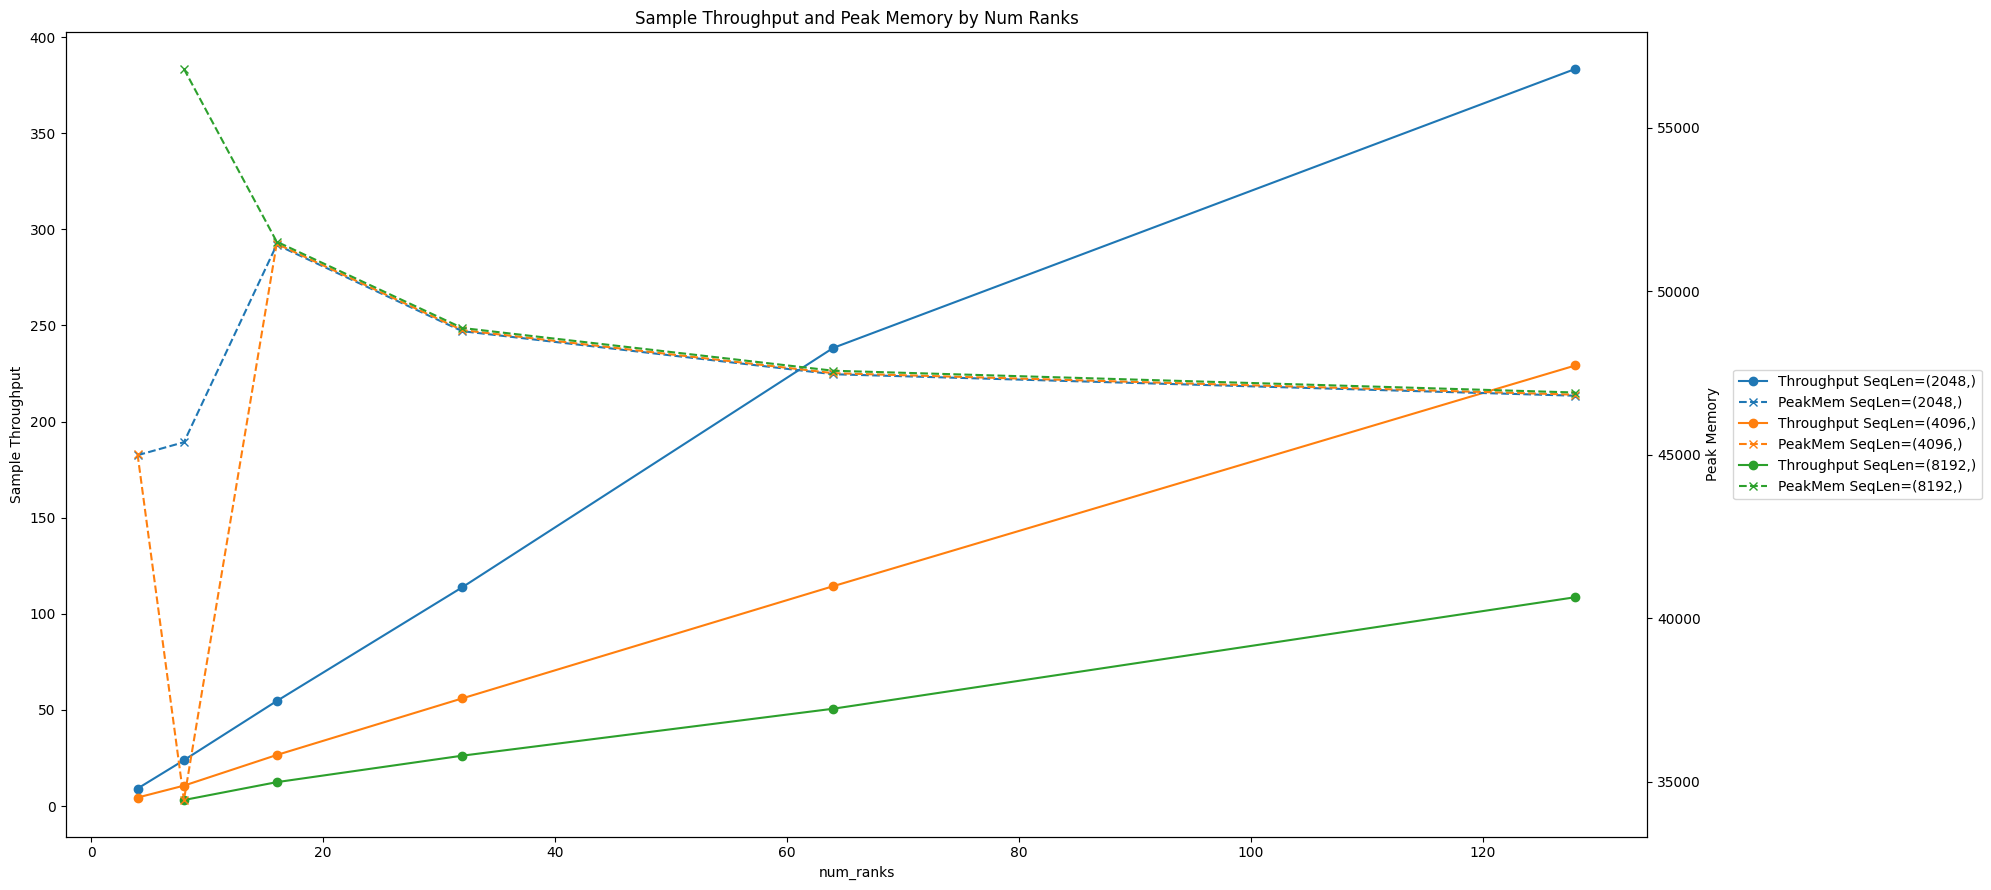

In [15]:

# Plot token throughput
fig, ax1 = plt.subplots(figsize=(20, 9))
ax2 = ax1.twinx()

# Store all line handles and labels for a single legend later
lines = []
labels = []

# Group by sequence_length and batch_size
for (seq_len), group in filtered_df.groupby(['sequence_length']):
    label = f'SeqLen={seq_len}'
    
    group_sorted = group.sort_values('num_ranks')
    
    # Plot sample_throughput
    l1, = ax1.plot(group_sorted['num_ranks'], group_sorted['sample_throughput'],
                   marker='o', label=f'Sample Throughput {label}')
    lines.append(l1)
    labels.append(f'Throughput {label}')
    
    # Plot peak_memory
    l2, = ax2.plot(group_sorted['num_ranks'], group_sorted['peak_memory'],
                   marker='x', linestyle='--', label=f'PeakMem {label}')
    lines.append(l2)
    labels.append(f'PeakMem {label}')

# Labels and titles
ax1.set_xlabel('num_ranks')
ax1.set_ylabel('Sample Throughput')
ax2.set_ylabel('Peak Memory')
ax1.set_title('Sample Throughput and Peak Memory by Num Ranks')

# Single combined legend
ax1.legend(lines, labels, loc='center left', bbox_to_anchor=(1.05, 0.5))

plt.tight_layout()
plt.show()



#### Bonus: Throughput degradation when hitting the memory limits


GPUs become highly inefficient when approaching the memory limits. This can be seen when plotting the throughput and peak memory usage against the batch size. The throughput increases until a peak memory of about 52GB of the available 65GB is reached. After that the throughput decreases significantly.

This is an important learning why scaling is so important. With GPUs exhibitiung various optimizations internally and advancements like Flash Attention, FSDP or selective activation checkpointing, the throughput function is not monotonic w.r.t. batch size, sequence length or number of ranks. Thus, it is crucial to perform scaling benchmarks to find the optimal configuration for a given number of ranks and hardware setup.

In [16]:
agg_df.head()

,batch_size,sequence_length,num_ranks,token_throughput,sample_throughput,peak_memory
0,1,2048,4,15370.963196,7.505353,35296.321289
1,1,2048,8,26812.143071,13.091867,23768.926758
2,1,2048,16,57784.448841,28.215063,18431.541992
3,1,2048,32,104614.175002,51.081140,15761.099609
4,1,2048,64,243072.793877,118.687888,14428.253906


In [17]:
# Assuming your DataFrame is named 'agg_df'

# Step 1: Find the maximum peak_memory per group
max_peak_per_group = (
    agg_df.groupby(['sequence_length', 'num_ranks'])['peak_memory']
    .max()
    .reset_index()
)

# Step 2: Sort groups by peak_memory descending and pick the top 5 groups
top_5_groups = (
    max_peak_per_group
    .sort_values(by='peak_memory', ascending=False)
    .head(5)
)

# Step 3: Filter the original DataFrame to include only rows from the top 5 groups
df_filtered = agg_df.merge(
    top_5_groups[['sequence_length', 'num_ranks']],
    on=['sequence_length', 'num_ranks'],
    how='inner'
)
df_filtered

,batch_size,sequence_length,num_ranks,token_throughput,sample_throughput,peak_memory
0,1,2048,4,15370.963196,7.505353,35296.321289
1,1,2048,8,26812.143071,13.091867,23768.926758
2,1,4096,8,43496.198726,10.619189,34438.700684
3,1,8192,8,25679.271291,3.134677,56797.747559
4,1,8192,16,101812.336060,12.428264,51513.366699
5,2,2048,4,18638.547231,9.100853,44982.962402
6,2,2048,8,44730.548782,21.841088,34406.700684
7,2,4096,8,26689.114011,6.515897,56733.747559
8,3,2048,4,12260.587309,5.986615,55957.587402
9,3,2048,8,48876.273119,23.865368,45381.200684


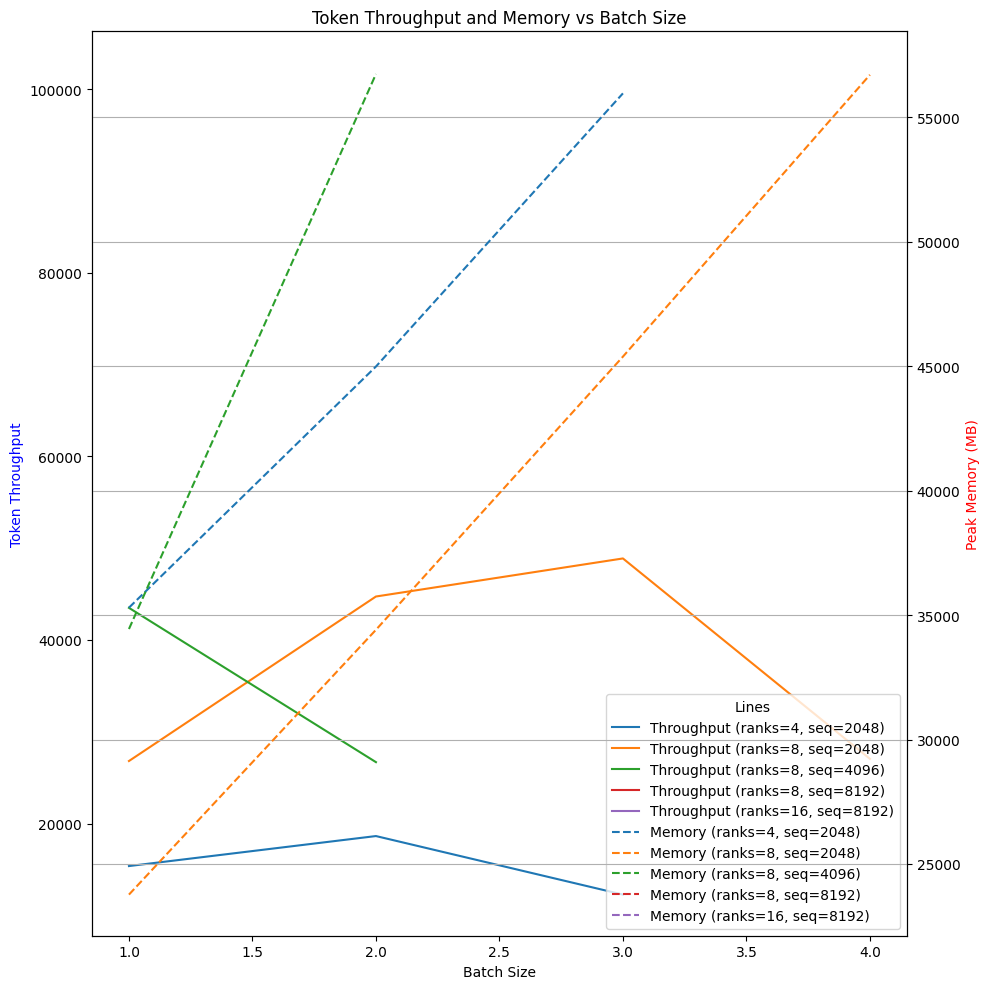

In [18]:
# Clean data
df = df_filtered[(df_filtered["token_throughput"] > 0) & (df_filtered["peak_memory"] > 0)]

# Start figure
fig, ax1 = plt.subplots(figsize=(10, 10))
ax2 = ax1.twinx()

# Color cycle for consistency across axes
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, ((num_ranks, seq_len), group) in enumerate(df.groupby(["num_ranks", "sequence_length"])):
    color = colors[i % len(colors)]
    
    # Aggregate by batch_size
    grouped = group.groupby("batch_size").agg({
        "token_throughput": "sum",
        "peak_memory": "max"
    })

    ax1.plot(grouped.index, grouped["token_throughput"], label=f"Throughput (ranks={num_ranks}, seq={seq_len})", color=color, linestyle='-')
    ax2.plot(grouped.index, grouped["peak_memory"], label=f"Memory (ranks={num_ranks}, seq={seq_len})", color=color, linestyle='--')

# Labels and legends
ax1.set_xlabel("Batch Size")
ax1.set_ylabel("Token Throughput", color='blue')
ax2.set_ylabel("Peak Memory (MB)", color='red')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="lower right", title="Lines")

plt.title("Token Throughput and Memory vs Batch Size")
plt.grid(True)
plt.tight_layout()
plt.show()

## Optimizing LLM pretraining

Optimizing the efficiency of LLM-pretraining is somewhat different from the plain scaling experiments above.
Besides typically having a fixed number of ranks, we cannot simply scale up the data parallel ranks and batch size, as a training step is typically constrained by the total number of tokens per step (e.g., 6M tokens). In these cases, we typically reduce the number of data parallel ranks by methods like tensor parallelism (see: https://docs.pytorch.org/tutorials/intermediate/TP_tutorial.html#when-and-why-you-should-apply-tensor-parallel). 

In this part of the tutorial, we will measure the efficiency of the 8B model with a sequence length of 2048 on 16 nodes (i.e., 64 GPUs).
Given a targeted number of tokens per step of 6M, the local batch size is 12. As we will see, even with full activation checkpointing and Flash Attention, the memory footprint is still too high to run a training step. Thus, in practice we would lower the batch size and resort to gradient acccumulation.

Additionally, we will all combinatoins of the following configurations:

* FSDP2-wrapped, FSDP2-wrapped + torch.compile
* Selective ops-based Activation Checkpointing, Full Activation Checkpointing
* Pytorch Flash Attention, Dao Flash Attention, baseline attention implementation

In [ ]:
! bash run_array_jobs.sh \
  --config_file config_8B_pretraining_optimization.yaml \
  --experiment_folder experiments \
  --python_env_path /leonardo_scratch/fast/EUHPC_D21_101/max_lue/python_envs/working/leonardo_modalities/bin/activate \
  --num_warmup_steps 4 \
  --num_measurement_steps 8 \
  --node_counts "32"

In [2]:
experiment_folder_path = Path("experiments/2025-06-05__00-33-03_16fe41ea")
experiment_dirs = list(experiment_folder_path.glob("*"))
experiment_dirs

[PosixPath('experiments/2025-06-05__00-33-03_16fe41ea/num_ranks_64')]

In [3]:
grid_search_dims = ["batch_size", "fsdp2_input_model", "attention_implementation"]

In [4]:
results_list: list[pd.DataFrame] = []
for experiment_dir in experiment_dirs:
    results: list[ProfilingResult] = ProfileLogsAnalyzer.load_profiling_logs(experiment_dir)
    df: pd.DataFrame = ProfileLogsAnalyzer.to_pandas_df(results)
    results_list.append(df)

df_results = pd.concat(results_list, ignore_index=True)
df_results.head()

,attention_implementation,batch_size,fsdp2_input_model,sequence_length,vocab_size,local_rank,global_rank,num_ranks,hostname,peak_memory,forward_time,backward_time,step_time,error
0,dao_flash,10,full_activation_checkpointed_model,4096,50304,0,20,64,lrdn2242.leonardo.local,28793.066895,0.073061,7.282772,0.201516,
1,dao_flash,2,model_raw,4096,50304,3,15,64,lrdn2212.leonardo.local,47492.332520,0.057737,1.024814,0.069663,
2,pytorch_flash,7,selective_op_activation_checkpointed_model,4096,50304,1,5,64,lrdn2194.leonardo.local,-1.000000,-1.000000,-1.000000,-1.000000,<class 'torch.OutOfMemoryError'>: CUDA out of ...
3,pytorch_flash,7,selective_op_activation_checkpointed_model,4096,50304,3,31,64,lrdn2271.leonardo.local,-1.000000,-1.000000,-1.000000,-1.000000,<class 'torch.OutOfMemoryError'>: CUDA out of ...
4,manual,8,selective_op_activation_checkpointed_model,4096,50304,2,6,64,lrdn2194.leonardo.local,-1.000000,-1.000000,-1.000000,-1.000000,<class 'torch.OutOfMemoryError'>: CUDA out of ...


In [5]:
# check for non-OOM errors

df_results[(df_results["error"] != "") & (~df_results["error"].str.contains("OutOfMemoryError"))]

,attention_implementation,batch_size,fsdp2_input_model,sequence_length,vocab_size,local_rank,global_rank,num_ranks,hostname,peak_memory,forward_time,backward_time,step_time,error


In [6]:
df_results["total_step_time"] = df_results["forward_time"] + df_results["backward_time"] + df_results["step_time"]
df_results["token_throughput"] = df_results["sequence_length"] * df_results["batch_size"] / df_results["total_step_time"]
df_results["sample_throughput"] = df_results["token_throughput"] / df_results["sequence_length"]
df_results = df_results[(df_results["error"] == "")]

df_results.sort_values(by=["total_step_time"], inplace=True, ascending=True)
df_results.head()

,attention_implementation,batch_size,fsdp2_input_model,sequence_length,vocab_size,local_rank,global_rank,num_ranks,hostname,peak_memory,forward_time,backward_time,step_time,error,total_step_time,token_throughput,sample_throughput
2538,pytorch_flash,1,compiled_model,4096,50304,1,61,64,lrdn2363.leonardo.local,21542.785645,0.047790,0.212969,0.041791,,0.302551,13538.230670,3.305232
7207,pytorch_flash,1,compiled_model,4096,50304,1,1,64,lrdn2172.leonardo.local,21542.785645,0.046309,0.214561,0.041723,,0.302593,13536.326608,3.304767
2261,pytorch_flash,1,compiled_model,4096,50304,2,62,64,lrdn2363.leonardo.local,21542.785645,0.046939,0.213982,0.041689,,0.302610,13535.584062,3.304586
7136,pytorch_flash,1,compiled_model,4096,50304,3,3,64,lrdn2172.leonardo.local,21542.785645,0.046369,0.214506,0.041764,,0.302640,13534.239155,3.304258
7183,pytorch_flash,1,compiled_model,4096,50304,0,60,64,lrdn2363.leonardo.local,21542.785645,0.046442,0.214455,0.041752,,0.302648,13533.860657,3.304165


In [10]:
# aggregate over the ranks of each experiment
agg_df = df_results.groupby(grid_search_dims).agg({
        "token_throughput": "sum",
        "sample_throughput": "sum",
        "peak_memory": "max"
    }).reset_index()

with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', None
):
    display(agg_df.sort_values(by=["token_throughput"], ascending=False))

,batch_size,fsdp2_input_model,attention_implementation,token_throughput,sample_throughput,peak_memory
2,1,compiled_model,pytorch_flash,864564.903864,211.075416,21542.785645
1,1,compiled_model,manual,726680.950268,177.412341,21543.285645
0,1,compiled_model,dao_flash,724501.241371,176.880186,21542.785645
12,2,compiled_model,dao_flash,716025.785900,174.810983,40315.332520
14,2,compiled_model,pytorch_flash,710691.281689,173.508614,40315.332520
26,3,compiled_model,pytorch_flash,708393.226240,172.947565,59402.270020
24,3,compiled_model,dao_flash,701355.696598,171.229418,59402.270020
25,3,compiled_model,manual,694344.006602,169.517580,59401.395020
13,2,compiled_model,manual,690549.246119,168.591125,40315.332520
19,2,model_raw,manual,463935.678378,113.265546,47492.332520


In [1]:
print(agg_df.to_csv())

NameError: name 'agg_df' is not defined

In [ ]:



# agg_df["mfu"] = agg_df.apply(
#     lambda row: get_mfu(num_params, n_layer, sequence_length, n_embd, row["sample_throughput"]), axis=1
# )
# agg_df




In [ ]:
def get_mfu(num_params: int, n_layer: int, sequence_length: int, n_embd: int, num_samples_per_second: float, num_ranks: int) -> float:
    theoretical_gpu_peak_performance_performance_A100 = 358e12

    theoretical_flops_per_token = 6 * num_params + 12 * n_layer * sequence_length * n_embd

    num_tokens_per_second = num_samples_per_second * sequence_length / num_ranks
    mfu = num_tokens_per_second * theoretical_flops_per_token / theoretical_gpu_peak_performance_performance_A100
    return mfu

n_layer = 32
sequence_length = 4096
num_params = 7391944704
n_embd = 4096
num_ranks = 64

get_mfu(num_params, n_layer, sequence_length, n_embd, 211, num_ranks)

1.9159882269404245

In [19]:
def get_mfu(
    num_params: int,
    sequence_length: int,
    num_samples_per_second: float,
    num_ranks: int,
    peak_flops_per_gpu: float = 358e12  # Adjust for FP16 A100
) -> float:
    """
    Calculate MFU for LLMs using the 6*num_params estimate from OpenAI GPT-3 paper.
    """
    # Estimated FLOPs per token (OpenAI estimate)
    flops_per_token = 6 * num_params
    
    # Global tokens per second (assuming num_samples_per_second is global)
    tokens_per_second = num_samples_per_second * sequence_length
    
    # Distribute tokens per GPU
    tokens_per_second_per_gpu = tokens_per_second / num_ranks
    
    # Achieved FLOPs per second per GPU
    achieved_flops = tokens_per_second_per_gpu * flops_per_token
    
    # MFU
    mfu = achieved_flops / peak_flops_per_gpu
    
    return mfu


get_mfu(num_params, sequence_length, 211, num_ranks)

NameError: name 'num_params' is not defined